In [1]:
import pandas as pd

C:\Users\voqua\AppData\Local\Temp\ipykernel_32688\4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [7]:
#not very efficient WR, equally expensive jail, WR, and HD
myDF = pd.read_csv("../dataset/placementDecisions_rl_los_cost_5.csv")

In [8]:
myDF.columns

Index(['Unnamed: 0', 'ocp_jl_low_los', 'ocp_jl_total', 'ocp_wr_low_los',
       'ocp_wr_total', 'ocp_hd_low_los', 'ocp_hd_total', 'class_mild', 'need',
       'placement'],
      dtype='object')

In [9]:
myDF.drop(['Unnamed: 0'], inplace = True, axis = 1)

In [10]:
# one hot encoding  -> the target is "placement", so we don't need to encode this column, also bcz RandomForest can handle categorical target data
# work release = 0 | home detention = 1 | jail = 2
for ind, item in myDF.iterrows():
    if item['placement'] == 'work release':
        myDF['placement'].iat[ind] = '0'
    elif item['placement'] == 'home detention':
        myDF['placement'].iat[ind] = '1'
    elif item['placement'] == 'jail':
        myDF['placement'].iat[ind] = '2'

#object to int
myDF['placement'] = pd.to_numeric(myDF['placement'])

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## A random model acting as a baseline for performance comparison

In [13]:
y = myDF["placement"]
X = myDF.drop(["placement"], axis = 1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size = 0.7, random_state = 50)

In [15]:
rf5 = RandomForestClassifier(random_state= 50)
rf5.fit(X_train, y_train)

RandomForestClassifier(random_state=50)

In [18]:
rf5.feature_importances_ 

array([0.05114084, 0.05433742, 0.05354913, 0.55373472, 0.05098454,
       0.05352053, 0.05461817, 0.12811465])

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [17]:
y_pred = rf5.predict(X_test)
print('f1_score' + str(f1_score(y_test, y_pred, average='weighted')))
print('precision_score: ' + str(precision_score(y_test, y_pred, average ='weighted')))
print('recall_score: ' + str(recall_score(y_test, y_pred, average ='weighted')))

f1_score0.791871112109315
precision_score: 0.7922331619202786
recall_score: 0.7916041979010495


## Fine-tuning a model and Optimizing the performance

In [24]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [25]:
param_grid = {'n_estimators': [100,150,200, 230], 'max_depth': [None, 5, 10], 
              'min_samples_leaf': [2, 5, 10],
              'min_samples_split': [2, 4, 6], 'max_features': ["sqrt", "log2", None]}

In [26]:
sh = HalvingGridSearchCV(rf5, param_grid, cv = 5, factor = 2, random_state=50).fit(X_train, y_train)

In [19]:
sh.best_params_

{'max_depth': 5,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 100}

In [27]:
sh.best_params_

{'max_depth': 10,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 200}

In [28]:
rf2a = RandomForestClassifier(max_depth= 10, max_features = None, min_samples_leaf = 2,
 min_samples_split = 6, n_estimators = 200, random_state= 50)

In [29]:
rf2a.fit(X_train, y_train)
y_preda = rf2a.predict(X_test)
print('f1_score:' + str(f1_score(y_test, y_preda, average='weighted')))
print('precision_score: ' + str(precision_score(y_test, y_preda, average ='weighted')))
print('recall_score: ' + str(recall_score(y_test, y_preda, average ='weighted')))

f1_score:0.8131204867064248
precision_score: 0.8129649616842193
recall_score: 0.8133433283358321


In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, rf2a.predict_proba(X_test), multi_class='ovr' )

0.934775238993019

## SHAP LIBRARY - DATA INTERPRETATION

In [22]:
import shap

c:\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
explainer5 = shap.TreeExplainer(rf2a)
shap_values5 = explainer5(X_train)

In [26]:
pd5_wr = pd.DataFrame(shap_values5[:,:,0].values, columns=rf2a.feature_names_in_)

In [27]:
pd5_hd = pd.DataFrame(shap_values5[:,:,1].values, columns=rf2a.feature_names_in_)

In [28]:
pd5_jl = pd.DataFrame(shap_values5[:,:,2].values, columns=rf2a.feature_names_in_)

In [29]:
pd5_wr.to_csv("pd5_wr_tuned.csv", index = False)

In [30]:
pd5_hd.to_csv("pd5_hd_tuned.csv", index = False)

In [31]:
pd5_jl.to_csv("pd5_jl_tuned.csv", index = False)

Work Release

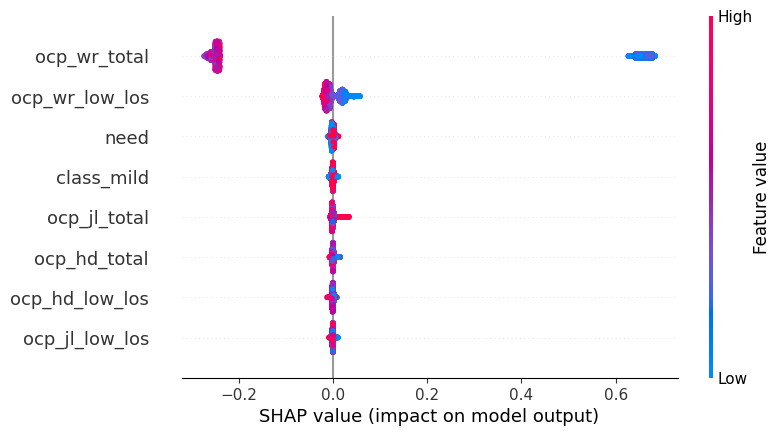

In [32]:
shap.plots.beeswarm(shap_values5[:,:,0])

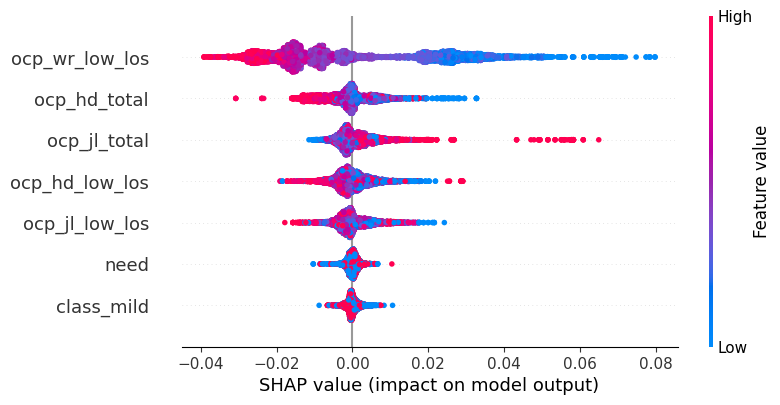

In [17]:
# Beeswarm without the dominant feature (ocp_wr_total)
shap.plots.beeswarm(shap_values5[:,[0,1,2,4,5,6,7],0])

Home Detention

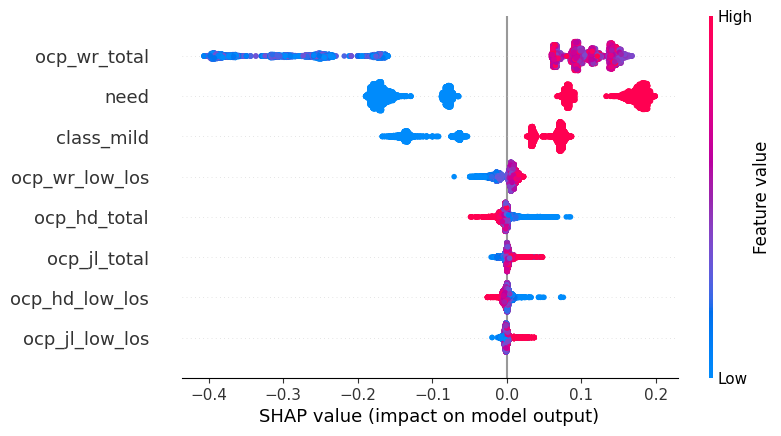

In [33]:
shap.plots.beeswarm(shap_values5[:,:,1])

Jail

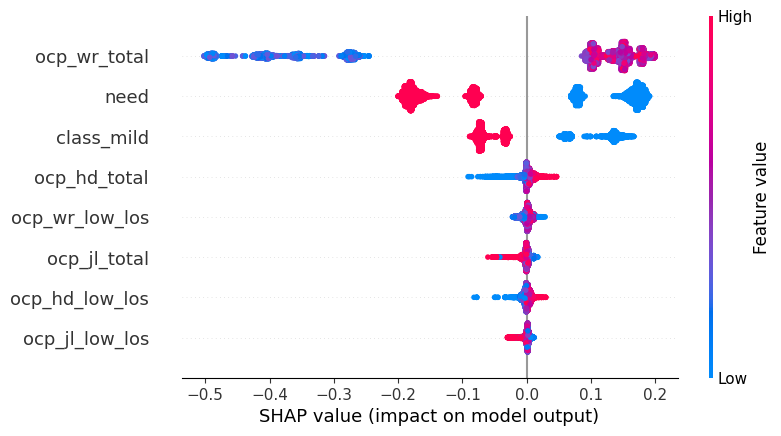

In [34]:
shap.plots.beeswarm(shap_values5[:,:,2])

All 3 placements

In [35]:
shap_as_list = []
for i in range(rf5.n_classes_):
    shap_as_list.append(shap_values5.values[:,:,i])

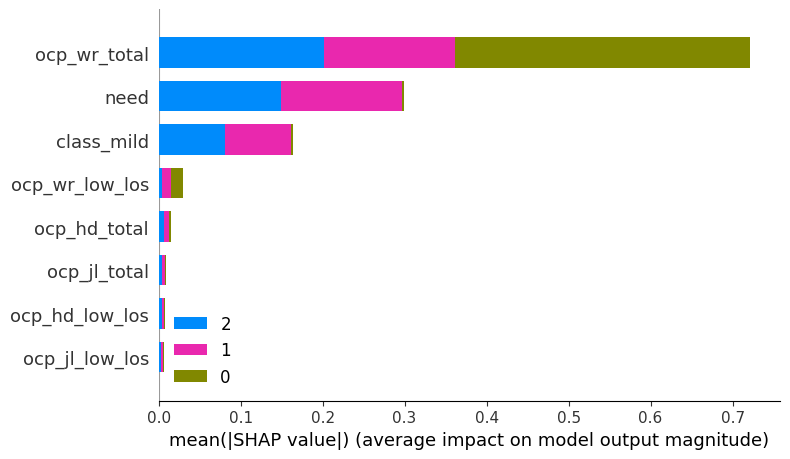

In [36]:
#tuned
shap.summary_plot(shap_as_list, X_train, plot_type="bar", class_names= rf5.classes_)

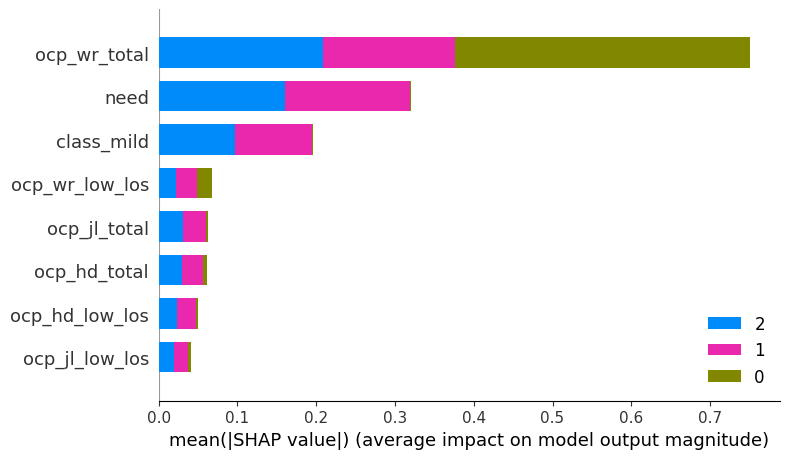

In [19]:
#pre_tuned
shap.summary_plot(shap_as_list, X_train, plot_type="bar", class_names= rf5.classes_)

## Data Progression

<Axes: >

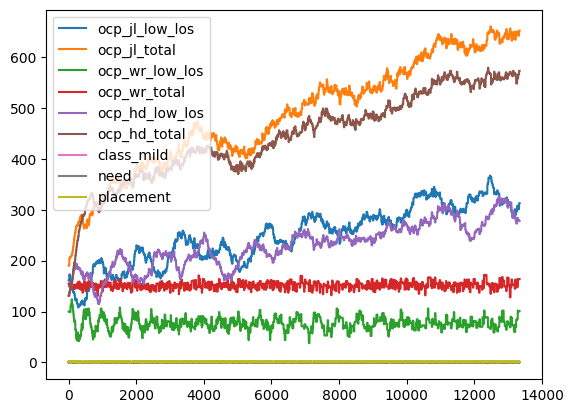

In [6]:
myDF.plot()